# Guided Project: Winning Jeopardy

## Introduction

In this project, we'll be looking at a dataset of Jeopardy's (a popular TV show in the US where participants answer questions to win money) questions to figure out some patterns in the questions that could help with winning.

## Exploring the dataset

In [1]:
# Read in the dataframe
import pandas as pd
jeopardy = pd.read_csv("jeopardy.csv")
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [2]:
# Print out the columns
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [3]:
# Remove spaces from column names
jeopardy.columns = jeopardy.columns.str.lstrip(" ")
jeopardy.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

## Normalizing Text

In [4]:
# Function to normalize all text columns
import re
def normalize(string):
    string = string.lower()
    string = re.sub(r'[^\w\s]', '', string)
    return string

In [5]:
# Normalize the Question column
jeopardy["clean_question"] = jeopardy["Question"].apply(normalize)
jeopardy["clean_answer"] = jeopardy["Answer"].apply(normalize)

print(jeopardy["clean_question"])
print('\n')
print(jeopardy["clean_answer"])

0        for the last 8 years of his life galileo was u...
1        no 2 1912 olympian football star at carlisle i...
2        the city of yuma in this state has a record av...
3        in 1963 live on the art linkletter show this c...
4        signer of the dec of indep framer of the const...
                               ...                        
19994    of 8 12 or 18 the number of us states that tou...
19995                             the new power generation
19996    in 1589 he was appointed professor of mathemat...
19997    before the grand jury she said im really sorry...
19998    llamas are the heftiest south american members...
Name: clean_question, Length: 19999, dtype: object


0             copernicus
1             jim thorpe
2                arizona
3              mcdonalds
4             john adams
              ...       
19994                 18
19995             prince
19996            galileo
19997    monica lewinsky
19998             camels
Name: clean_answer, Len

## Normalizing Columns

In [6]:
# Function to normalize dollar values
def normalize_dollar(string):
    string = re.sub(r'[^\w\s]', '', string)
    if string == 'None':
        integer = 0
    else:
        integer = int(string)
    return integer

# Normalize the Value column
jeopardy["clean_value"] = jeopardy["Value"].apply(normalize_dollar)
jeopardy["clean_value"]

0        200
1        200
2        200
3        200
4        200
        ... 
19994    200
19995    200
19996    200
19997    200
19998    200
Name: clean_value, Length: 19999, dtype: int64

In [7]:
# Convert Air Date column to a datetime column
jeopardy["Air Date"] = pd.to_datetime(jeopardy["Air Date"]) 

In [8]:
jeopardy.dtypes

Show Number                int64
Air Date          datetime64[ns]
Round                     object
Category                  object
Value                     object
Question                  object
Answer                    object
clean_question            object
clean_answer              object
clean_value                int64
dtype: object

## Answers in Questions

In order to figure out whether to study past questions, study general knowledge, or not study it all, it would be helpful to figure out two things:

- How often the answer can be used for a question.
- How often questions are repeated.

In [9]:
def answer_question(row):
    split_answer = row["clean_answer"].split()
    split_question = row["clean_question"].split()
    match_count = 0

    # Remove 'the' from the answers
    if "the" in split_answer:
        split_answer.remove("the")
    if len(split_answer) == 0:
        return 0
    for item in split_answer:
        if item in split_question:
            match_count += 1
    return match_count / len(split_answer)

In [10]:
jeopardy["answer_in_question"] = jeopardy.apply(answer_question, axis=1)
jeopardy["answer_in_question"].mean()

0.059001965249777744

## Recyled Questions

New questions can be repeats of older ones. Though we can't fully answer this question as we have only about 10% of the full Jeopardy question dataset, we can at least investigate this by checking if the terms of more than 6 or more characters have been previously used or not.

In [11]:
# Create an empty list
question_overlap = []

# Create an empty set
terms_used = set()

# Sort jeopardy by ascending air date
jeopardy = jeopardy.sort_values("Air Date")

In [12]:
# Loop through each row of jeopardy
for i, row in jeopardy.iterrows():
        # Split clean_question into words
        split_question = row["clean_question"].split(" ")
        # Remove any word shorter than 6 characters
        split_question = [q for q in split_question if len(q) > 5]
        match_count = 0
        # Check if each word occurs in terms_used
        for word in split_question:
            if word in terms_used:
                match_count += 1
        for word in split_question:
            terms_used.add(word)
        if len(split_question) > 0:
            match_count /= len(split_question)
        question_overlap.append(match_count)
jeopardy["question_overlap"] = question_overlap

jeopardy["question_overlap"].mean()

0.6876235590919714

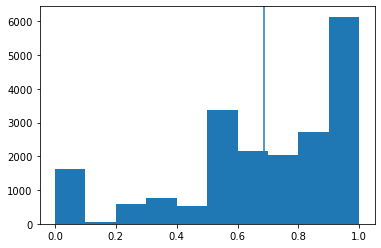

In [14]:
import matplotlib.pyplot as plt
plt.hist(jeopardy["question_overlap"])
plt.axvline(jeopardy["question_overlap"].mean())

In [16]:
jeopardy["question_overlap"].describe()

count    19999.000000
mean         0.687624
std          0.299120
min          0.000000
25%          0.500000
50%          0.750000
75%          1.000000
max          1.000000
Name: question_overlap, dtype: float64

## Low Value vs High Value Questions

We will look at high value questions because they help the participants earn more money.The questions can be broken down into two categories:
- Low value -- Any row where Value is less than 800.
- High value -- Any row where Value is greater than 800.

In [18]:
# Function that categorise value to low vs high
def low_high(row):
    if row["clean_value"] > 800:
        value = 1
    else:
        value = 0
    return value

In [20]:
# Apply the function to each row 
jeopardy["high_value"] = jeopardy.apply(low_high, axis=1)

In [24]:
# Function that calculate high_count and low_count
def word_count(word):
    low_count = 0
    high_count = 0
    # Loop through each row in jeopardy
    for i, row in jeopardy.iterrows():
        split_question = row["clean_question"].split(" ")
        if word in split_question:
            if row["high_value"] == 1:
                high_count +=1
            else:
                low_count += 1
    return high_count, low_count

In [38]:
# Randomly pick ten elements of terms_used
from random import choice

terms_used_list = list(terms_used)
comparison_terms = [choice(terms_used_list) for _ in range(10)]

# Create an empty list
observed_expected = []

# Loop through each term in comparison_terms
for i in comparison_terms:
    observed_expected.append(word_count(i))

In [39]:
print(comparison_terms)
print(observed_expected)

['fairfield', 'floored', 'delicate', '199091', 'churchills', 'linebackers', 'furnace', 'kontiki', 'tunneling', 'showing']
[(1, 0), (0, 1), (0, 4), (0, 1), (0, 1), (0, 2), (0, 1), (1, 0), (0, 1), (5, 2)]


## Applying the Chi-squared Test

In [48]:
high_value_count = jeopardy[jeopardy["high_value"] == 1]["high_value"].count()

low_value_count = jeopardy[jeopardy["high_value"] == 0].shape[0]

In [53]:
type(observed_expected[0])

tuple

In [64]:
import numpy as np
from scipy.stats import chisquare

# Create an empty list
chi_squared = []
p_values = []

# Loop through each list in observed_expected
for i in observed_expected:
    # Total of high and low counts
    total = i[0] + i[1]
    # Total proportion of total counts across the dataset
    total_prop = total / jeopardy.shape[0]
    
    expected_high_value_count = total_prop * high_value_count
    expected_low_value_count = total_prop * low_value_count

    observed = np.array([i[0], i[1]])
    expected = np.array([expected_high_value_count, expected_low_value_count])
    chisquare_value, pvalue = chisquare(observed, expected)
    chi_squared.append(chisquare_value)
    p_values.append(pvalue)

In [63]:
chi_squared

[2.487792117195675,
 0.401962846126884,
 1.607851384507536,
 0.401962846126884,
 0.401962846126884,
 0.803925692253768,
 0.401962846126884,
 2.487792117195675,
 0.401962846126884,
 6.2575220449142]

In [65]:
p_values

[0.11473257634454047,
 0.5260772985705469,
 0.2047940943922556,
 0.5260772985705469,
 0.5260772985705469,
 0.3699222378079571,
 0.5260772985705469,
 0.11473257634454047,
 0.5260772985705469,
 0.012366706058156086]

## Conclusion

As most p_values are larger than 0.05 (the typical threshold for statistical significance), we can conclude that the results are not statistically significant, meaning none of the terms had a significant difference in usage between high value and low value questions.